In [22]:
import numpy as np
from scipy.linalg import eigh, expm
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, transpile
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import PauliEvolutionGate, UnitaryGate
from qiskit.synthesis.evolution import LieTrotter
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram

In [23]:
def get_itimevol_circuit(M, H, t, psi_0, reps = 5):
    N = 3
    N_q = 2 ** N
    n_anc = 2 * M
    

    anc_idxs = list(range(n_anc))
    sys_idxs = list(range(n_anc, n_anc + N))
    alpha    = 2 * np.arctan(np.sqrt(0.5))
    beta     = 0.5 * np.pi
    gamma    = -1.5 * np.pi
    anc      = QuantumRegister(n_anc, name="a")
    syst     = QuantumRegister(N, name="q")
    qc       = QuantumCircuit(anc, syst)

    qc.initialize(psi_0, sys_idxs)

    for i in range(2 * M - 1, 0, -2): 
        """ Start from the last couple of qubits (most significative ones)
            and then go up until the least significative couple by steps 
            of two qubits.
        """
        # setup gates for ancillary qubits
        qc.ry(alpha, i - 1)
        qc.ry(beta, i)
        qc.cx(i - 1, i, ctrl_state = 0)
        qc.crz(gamma, control_qubit = i - 1, target_qubit = i)

        U_1    = expm(1j * H * t / M)
        U_1_op = UnitaryGate(U_1, label="U(-t/M)").control(1)
        qc.append(U_1_op, [i - 1] + sys_idxs) # control on qubit i - 1 and act on the system qubits

        U_2    = expm(-2j * H * t / M)
        U_2_op = UnitaryGate(U_2, label="U(2t/M)").control(2)
        qc.append(U_2_op, [i - 1, i] + sys_idxs) # control on qubits i - 1 and i and act on the system qubits

    # setup measurement qubits
    qc.h(anc_idxs)

    return qc

In [24]:
# consider 3 qubits
N = 3
N_q = 2 ** N
M = 3
n_anc = 2 * M
t = 1

A = np.random.rand(N_q, N_q) + 1j * np.random.rand(N_q, N_q) - 1
H = A + A.conj().T

evs, w = eigh(H)
w = w.T
gs = w[0]

a_values = np.linspace(0, 1, 5)
fs = []

for a_0 in a_values:
    psi_0 = a_0 * gs + np.sqrt(1 - a_0 ** 2) * w[1]
    psi_0 /= np.linalg.norm(psi_0)

    qc = get_itimevol_circuit(M, H, t, psi_0)
    qc.save_statevector()
    aer_sim = Aer.get_backend("aer_simulator_statevector_gpu")
    qc_tp = transpile(qc, backend=aer_sim)
    result = aer_sim.run(qc_tp).result()

    final_state_dict = result.get_statevector(qc_tp).to_dict()
    final_state_sys_dict = {}
    for k, v in final_state_dict.items():
        if k[-n_anc:] == '0' * n_anc: # check if the ancillary qubits are in the |0...0> state
            k_new = k[:N]
            final_state_sys_dict[k_new] = v
    final_state_sys_list = sorted(final_state_sys_dict.items())
    final_state = np.array([t[1] for t in final_state_sys_list])
    
    fs.append(np.abs(np.dot(gs, final_state)) ** 2)

In [25]:
evs[-1] * t

1.6178042586069126

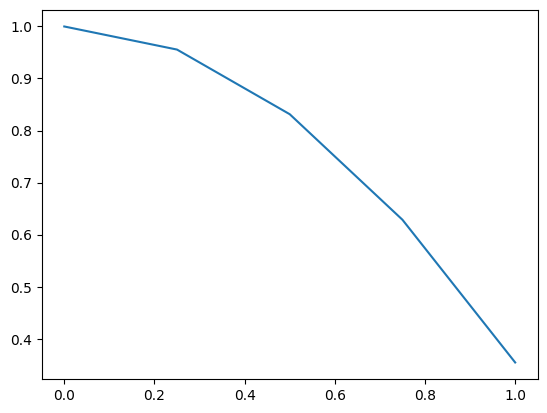

In [26]:
plt.plot(a_values, 1 - np.array(fs))